In [68]:
#  задание 2.3.1.1 импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve,

)


In [69]:
#  задание 2.3.1.2 Загрузка данных
df = pd.read_csv('S05-hw-dataset.csv')


In [70]:
# 2.3.1.3 задание первые строки датасета
df.head(10)
df.info()
df.describe()
print(df['default'].value_counts(normalize=True))
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [71]:
#  задание 2.3.1.4 анализ данных
# размер 3001 строк и 17 признаков  
# пропусков нету 
# распределение целового признака  default показало что датасет умеренно сбалансирован 
# баланс примерно классов 60/40
# все признаки без явных анамалий пропусков 




In [72]:
# задание 2.3.2.
y = df['default']
x = df.drop(columns=['client_id', 'default'])



In [73]:
# задание 2.3.3.1 разделение выборки на обучающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


default
0    0.5898
1    0.4102
Name: proportion, dtype: float64
default
0    0.5893
1    0.4107
Name: proportion, dtype: float64


In [60]:
#  задание 2.3.3.2 бейзлайн-модель на основе DummyClassifier
baseline_model = DummyClassifier(strategy='most_frequent', random_state=42)

baseline_model.fit(x_train, y_train)

# тестовая выборка, предсказания 
y_pred_baseline = baseline_model.predict(x_test)
y_pred_proba_baseline = baseline_model.predict_proba(x_test)[:, 1]
# задание 2.3.3.3 метрики качества базелайн-модели
baseline_roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
# задание 2.3.3.4 выаод результатов 
print(f"ROC-AUC:   {baseline_roc_auc:.4f}")
print(f"Accuracy:  {baseline_accuracy:.4f}")
#roc-auc показывает что модель не умеет отличать классы
# Accuracy показывает что модель чаще всего предсказывает класс 0



ROC-AUC:   0.5000
Accuracy:  0.5893


In [74]:
# задание 2.3.4.1 логистическая регессия с подбором гиперпараметров, построили pipline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# задание 2.3.4.2 определяем сетку гиперпараметров для перебора
param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0]

}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
# Обучаем модель с подбором гиперпараметров
grid_search.fit(x_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC : {grid_search.best_score_:.4f}")



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'logreg__C': 1.0}
Лучший ROC-AUC : 0.8632


In [75]:
# задание 2.3.4.3 получаем лучшую модель
best_model = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred_logreg = best_model.predict(x_test)
y_pred_proba_logreg = best_model.predict_proba(x_test)[:, 1]

# Метрики качества логистической регрессии
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)

print(f"Accuracy:  {logreg_accuracy:.4f}")
print(f"ROC-AUC:   {logreg_roc_auc:.4f}")



Accuracy:  0.7933
ROC-AUC:   0.8647


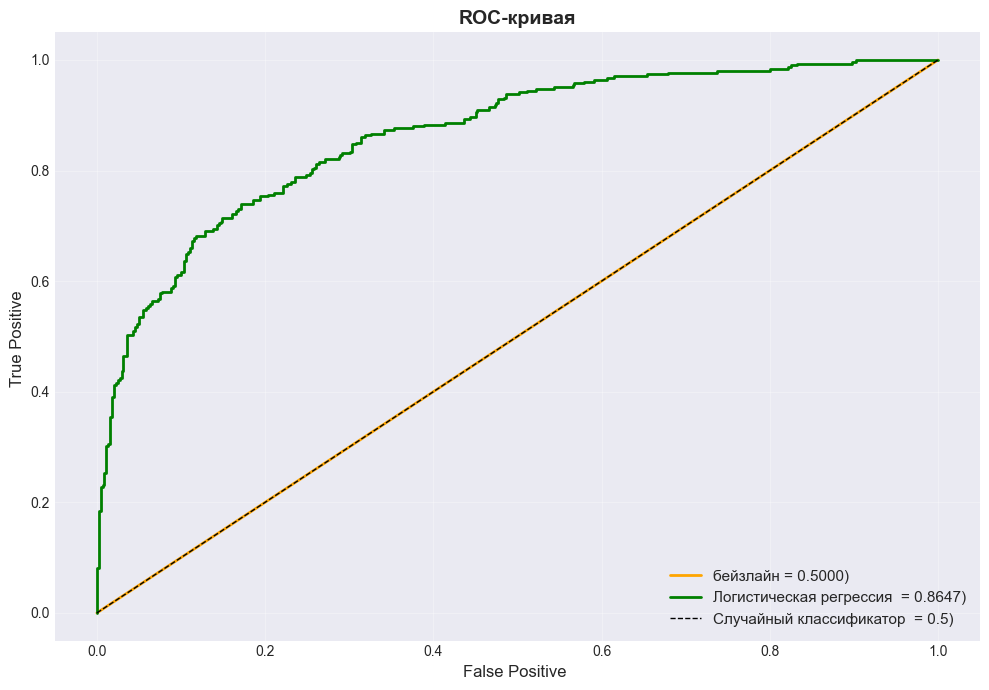

In [76]:
#задание 2.3.4.4
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)

# Строим ROC-кривую
plt.figure(figsize=(10, 7))
plt.plot(fpr_baseline, tpr_baseline, label=f'бейзлайн = {baseline_roc_auc:.4f})', 
         linestyle='-', linewidth=2, color='orange')
plt.plot(fpr_logreg, tpr_logreg, label=f'Логистическая регрессия  = {logreg_roc_auc:.4f})', 
         linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Случайный классификатор  = 0.5)')

plt.xlabel('False Positive ', fontsize=12)
plt.ylabel('True Positive ', fontsize=12)
plt.title('ROC-кривая', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
#задание 2.3.4.5
plt.savefig('figures/roc.png', dpi=300, bbox_inches='tight')
plt.show()


In [77]:
# Задание 2.3.5.1 Извлекаем результаты GridSearch для анализа влияния параметра C
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_logreg__C', 'mean_test_score', 'std_test_score']]
results.columns = ['C', 'Mean ROC-AUC (CV)', 'Std ROC-AUC (CV)']
results['C'] = results['C'].astype(float)
results = results.sort_values('C')

print("Результаты для разных значений C:")
print(results.to_string(index=False))



Результаты для разных значений C:
     C  Mean ROC-AUC (CV)  Std ROC-AUC (CV)
  0.01             0.8630            0.0126
  0.10             0.8632            0.0122
  1.00             0.8632            0.0122
 10.00             0.8631            0.0122
100.00             0.8631            0.0122


**1. Логистическая регрессия по сравнению с бейзлайном:**

Логистическая регрессия показала ROC-AUC = 0.8647 на тестовой выборке, что на +0.3647 выше бейзлайна 0.5000. 
Бейзлайн просто угадывал классы, всегда предсказывал "0", а логистическая регрессия 
продемонстрировала высокую различающую способность между классами.

**2. Интерпретация Accuracy:**

Accuracy бейзлайна составил 0.5893 — модель всегда предсказывала класс "0" нет дефолта. 
Логистическая регрессия показала accuracy = 0.7933 на тестовой выборке, что значительно превышает 
этот порог и демонстрирует реальную способность модели использовать признаки для предсказаний.

**3. Подбор гиперпараметра C:**

В результате GridSearchCV оптимальным оказалось значение C = 1.0, которое показало ROC-AUC = 0.8632 (на кросс-валидации). 
Также значение C = 0.1 показало идентичный результат 0.8632, что говорит 
о высокой устойчивости модели к выбору параметра регуляризации в этом диапазоне.

**Главный итог:**
Логистическая регрессия с C = 1.0 является лучшей моделью для данной задачи. 
Она существенно превосходит бейзлайн по всем метрикам (ROC-AUC: 0.8647 vs 0.5000, 
Accuracy: 0.7933 vs 0.5893) и демонстрирует практическую применимость для предсказания дефолта по кредиту.